# Proyek Deteksi Hoaks: Versi Tanpa Instalasi (Menggunakan Default Environment)

Notebook ini berisi alur kerja lengkap untuk melatih model deteksi hoaks menggunakan library yang sudah disediakan secara default oleh Google Colab. Pendekatan ini menghilangkan kebutuhan untuk `pip install` setiap kali sesi dimulai.

**Tahapan yang akan dilakukan:**
1.  **Setup & Cek Versi**: Mengimpor library dan memeriksa versi default.
2.  **Konfigurasi**: Menentukan hyperparameter dan path.
3.  **Memuat & Eksplorasi Data**: Memuat dataset dan memvisualisasikan distribusi kelas.
4.  **Persiapan Data**: Melakukan splitting dan tokenisasi teks.
5.  **Membuat `tf.data.Dataset`**: Menyiapkan data agar efisien untuk training.
6.  **Membangun & Mengompilasi Model**: Memuat IndoBERT dan menangani class imbalance.
7.  **Melatih Model**: Menjalankan proses `model.fit`.
8.  **Evaluasi Performa**: Menganalisis hasil training.
9.  **Menyimpan Model Final**: Menyimpan artefak yang siap untuk deployment.

#**Setup & Cek Versi Library Default**

In [1]:
# ==============================================================================
# SETUP LENGKAP & IMPORT SEMUA LIBRARY
# ==============================================================================

# Untuk manipulasi data
import pandas as pd
import numpy as np

# Untuk machine learning & deep learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Untuk model & tokenizer dari Hugging Face
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk interaksi dengan sistem operasi
import os

# Cek versi library yang digunakan
print("--- Versi Library Default yang Digunakan ---")
print("TensorFlow Version:", tf.__version__)
print("Transformers Version:", transformers.__version__)
print("Pandas Version:", pd.__version__)
print("NumPy Version:", np.__version__)
print("---------------------------------------------")

--- Versi Library Default yang Digunakan ---
TensorFlow Version: 2.18.0
Transformers Version: 4.52.4
Pandas Version: 2.2.2
NumPy Version: 2.0.2
---------------------------------------------


#**Konfigurasi & Hyperparameter**

In [2]:
# ==============================================================================
# KONFIGURASI & HYPERPARAMETER
# ==============================================================================
# Nama model dari Hugging Face
MODEL_NAME = "indobenchmark/indobert-base-p1"

# Nama folder untuk menyimpan model final (sesuaikan dengan nama di app.py)
FINAL_MODEL_DIR = "./hoax_classifier_final"

# Hyperparameter untuk training
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 3e-5

#**Memuat & Eksplorasi Data**

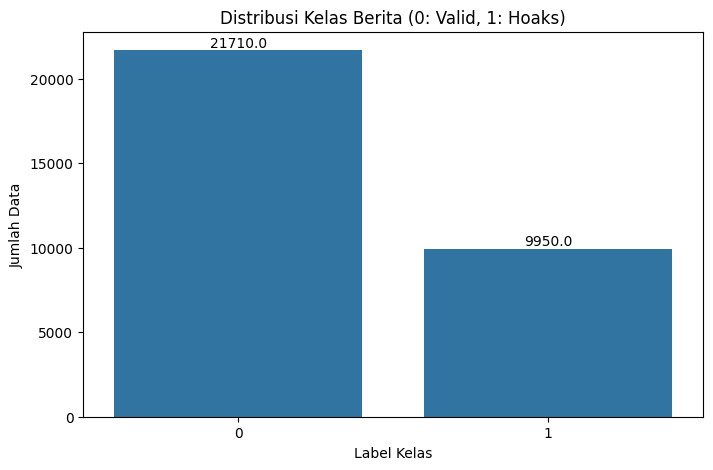

In [3]:
# ==============================================================================
# MEMUAT & EKSPLORASI DATA
# ==============================================================================
# Memuat dataset
df = pd.read_csv('preprocessed_text_label.csv')

# Membersihkan data
df.dropna(subset=['text_akhir'], inplace=True)
df.reset_index(drop=True, inplace=True)
df['label'] = df['label'].astype(int)

# Visualisasi distribusi kelas untuk melihat imbalance
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=df)
plt.title('Distribusi Kelas Berita (0: Valid, 1: Hoaks)')
plt.xlabel('Label Kelas')
plt.ylabel('Jumlah Data')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

#**Persiapan Data (Splitting & Tokenisasi)**

In [4]:
# ==============================================================================
# PERSIAPAN DATA (SPLITTING & TOKENISASI)
# ==============================================================================
# Membagi data dengan stratify untuk menjaga proporsi label
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text_akhir'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Inisialisasi tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Melakukan tokenisasi
print("\nMelakukan tokenisasi data...")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=MAX_LENGTH)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAX_LENGTH)
print("Tokenisasi selesai.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


Melakukan tokenisasi data...
Tokenisasi selesai.


#**Membuat tf.data.Dataset**

In [5]:
# ==============================================================================
# MEMBUAT TF.DATA.DATASET
# ==============================================================================
# Mengubah data ke format `tf.data.Dataset`
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(1000).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)

print("\n`tf.data.Dataset` berhasil dibuat.")


`tf.data.Dataset` berhasil dibuat.


#**Membangun & Mengompilasi Model**

In [6]:
# ==============================================================================
# MEMBANGUN & MENGOMPILASI MODEL
# ==============================================================================
# Menghitung bobot kelas untuk mengatasi data tidak seimbang
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights yang akan digunakan: {class_weight_dict}")

# Memuat model pra-terlatih
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Mengompilasi model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print("\nModel berhasil dibuat dan dikompilasi.")
model.summary()

Class weights yang akan digunakan: {0: np.float64(0.7291570704744358), 1: np.float64(1.5909547738693468)}


tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model berhasil dibuat dan dikompilasi.
Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  124441344 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 124442882 (474.71 MB)
Trainable params: 124442882 (474.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#**Melatih Model**

In [ ]:
# ==============================================================================
# MELATIH MODEL
# ==============================================================================
# Callback untuk menyimpan hanya model dengan performa terbaik
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./best_tf_model.weights.h5",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

print(f"\nMemulai training model untuk {EPOCHS} epochs...")

# Melatih model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_callback]
)

print("\nTraining selesai.")


Memulai training model untuk 5 epochs...
Epoch 1/5
1583/1583 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9481

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


1583/1583 [==============================] - 1018s 586ms/step - loss: 0.1418 - accuracy: 0.9481 - val_loss: 0.1420 - val_accuracy: 0.9534
Epoch 2/5
1583/1583 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9697

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


1583/1583 [==============================] - 919s 580ms/step - loss: 0.0830 - accuracy: 0.9697 - val_loss: 0.1324 - val_accuracy: 0.9586
Epoch 3/5
1583/1583 [==============================] - 899s 568ms/step - loss: 0.0618 - accuracy: 0.9775 - val_loss: 0.2690 - val_accuracy: 0.9454
Epoch 4/5
 826/1583 [==============>...............] - ETA: 6:32 - loss: 0.0497 - accuracy: 0.9828

#**Evaluasi Performa Model**

In [ ]:
# ==============================================================================
# EVALUASI PERFORMA MODEL
# ==============================================================================
# Load kembali bobot terbaik yang telah disimpan
print("\nMemuat bobot model terbaik untuk evaluasi akhir...")
model.load_weights("./best_tf_model.weights.h5")

# Prediksi pada data validasi
val_predictions_logits = model.predict(val_dataset).logits
val_predictions = np.argmax(val_predictions_logits, axis=1)

# Menampilkan classification report
print("\n--- LAPORAN KLASIFIKASI AKHIR ---")
print(classification_report(val_labels, val_predictions, target_names=['Valid (Kelas 0)', 'Hoaks (Kelas 1)']))

# Menampilkan confusion matrix
print("\n--- CONFUSION MATRIX ---")
cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prediksi Valid', 'Prediksi Hoaks'],
            yticklabels=['Asli Valid', 'Asli Hoaks'])
plt.ylabel('Label Asli')
plt.xlabel('Label Prediksi')
plt.title('Confusion Matrix')
plt.show()

#**Menyimpan Model Final untuk Deployment**

In [ ]:
# ==============================================================================
# MENYIMPAN MODEL FINAL UNTUK DEPLOYMENT
# ==============================================================================
# Menyimpan model dan tokenizer dengan cara yang benar
print(f"\nMenyimpan model dan tokenizer final ke direktori: '{FINAL_MODEL_DIR}'")
if not os.path.exists(FINAL_MODEL_DIR):
    os.makedirs(FINAL_MODEL_DIR)

model.save_pretrained(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)

print("\n✅ Proses Selesai! Folder model siap untuk digunakan di Streamlit.")